In [16]:


import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from collections import defaultdict

In [17]:
SIZE_IMAGE = 20
NUM_CLASSES = 10

def load_digits_and_labels(big_image):
    """Returns all the digits from the 'big' image and creates the correspnding label for each image """

    digits_img = cv2.imread(big_image, 0)

    #Get all the digit image
    number_rows = digits_img.shape[1] / SIZE_IMAGE
    rows = np.vsplit(digits_img, digits_img.shape[0] /SIZE_IMAGE)

    digits = []
    for row in rows:
        row_cells = np.hsplit(row, number_rows)
        for digit in row_cells:
            digits.append(digit)
    digits = np.array(digits)

    #creating the labels
    labels = np.repeat(np.arange(NUM_CLASSES), len(digits) / NUM_CLASSES)
    return digits, labels 



def get_accuracy(predictions, labels):

    accuracy = (np.squeeze(predictions) == labels).mean()
    return accuracy * 100

def raw_pixels(img):
    return img.flatten()

Pre-Processing

The ``deskew()`` function de-skews the digit by using its second-order moments.
More specifically, a measure of the skew can be calculated by the ratio of the
two central moments ``(mu11/mu02)``. The calculated skew is used in calculating
an affine transformation, which de-skews the digits.

In [18]:
def deskew(img):
    """Pre-processing of the image"""

    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SIZE_IMAGE * skew],[0, 1, 0]])
    img = cv2.warpAffine(img, M, (SIZE_IMAGE, SIZE_IMAGE), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

    return img

In [19]:
digits, labels = load_digits_and_labels('images/digits.png')

In [20]:
#Shuffling data
rand = np.random.RandomState(1234)

#randomly permute the sequence
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]

#compute the descriptors for all the images 

raw_descriptors = []
for img in digits:
    raw_descriptors.append(np.float32(raw_pixels(img)))
raw_descriptors = np.squeeze(raw_descriptors)

In [21]:
# Split data into training/testing:
split_values = np.arange(0.1, 1, 0.1)

# Create a dictionary to store the accuracy when testing:
results = defaultdict(list)

# Create KNN:
knn = cv2.ml.KNearest_create()

for split_value in split_values:
    # Split the data into training and testing:
    partition = int(split_value * len(raw_descriptors))
    raw_descriptors_train, raw_descriptors_test = np.split(raw_descriptors, [partition])
    labels_train, labels_test = np.split(labels, [partition])

    # Train KNN model
    print('Training KNN model - raw pixels as features')
    knn.train(raw_descriptors_train, cv2.ml.ROW_SAMPLE, labels_train)

    # Store the accuracy when testing:
    for k in np.arange(1, 10):
        ret, result, neighbours, dist = knn.findNearest(raw_descriptors_test, k)
        acc = get_accuracy(result, labels_test)
        print(" {}".format("%.2f" % acc))
        results[int(split_value * 100)].append(acc)


Training KNN model - raw pixels as features
 85.89
 83.33
 84.73
 84.82
 84.64
 84.73
 84.20
 83.42
 82.89
Training KNN model - raw pixels as features
 89.42
 87.70
 88.98
 89.03
 89.00
 88.20
 88.40
 87.88
 87.83
Training KNN model - raw pixels as features
 91.77
 90.06
 91.09
 90.94
 91.31
 90.77
 90.80
 90.43
 90.03
Training KNN model - raw pixels as features
 92.43
 91.13
 92.07
 91.83
 91.60
 91.47
 91.67
 91.20
 91.03
Training KNN model - raw pixels as features
 93.72
 91.96
 93.00
 92.64
 92.60
 92.40
 92.28
 92.44
 91.96
Training KNN model - raw pixels as features
 94.10
 92.50
 93.85
 92.95
 93.15
 92.95
 92.80
 93.25
 92.45
Training KNN model - raw pixels as features
 95.13
 93.53
 94.33
 93.93
 94.27
 93.60
 93.73
 93.67
 93.00
Training KNN model - raw pixels as features
 95.90
 94.20
 95.10
 94.40
 95.10
 94.60
 94.50
 94.60
 94.50
Training KNN model - raw pixels as features
 95.80
 94.80
 95.00
 95.40
 95.20
 95.20
 95.60
 95.20
 95.20


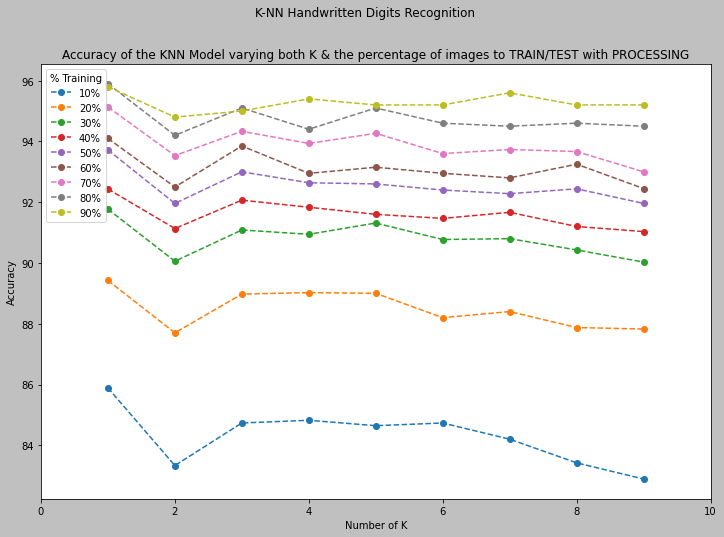

In [22]:
fig = plt.figure(figsize=(12, 8))
plt.rcParams['figure.facecolor'] ='silver'
plt.suptitle("K-NN Handwritten Digits Recognition")


ax = plt.subplot(1, 1, 1)
ax.set_xlim(0, 10)
dim = np.arange(1, 10)

for key in results:
    ax.plot(dim, results[key], linestyle='--', marker='o', label=str(key) + "%")

plt.legend(loc="upper left", title="% Training")
plt.title("Accuracy of the KNN Model varying both K & the percentage of images to TRAIN/TEST with PROCESSING")
plt.xlabel("Number of K")
plt.ylabel("Accuracy")
plt.show()